In [172]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import functools
import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping

from math import sqrt
import pandas as pd
from shapely.ops import cascaded_union
pd.set_option('precision', 10)
import pysal as ps

In [3]:
import math
import geoplot as gplt

In [2]:
import utilities as uf

In [209]:
from importlib import reload

In [223]:
reload(uf)

<module 'utilities' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\utilities.py'>

In [5]:
#initialise path, names, etc.

city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

In [6]:
# try reading nodes, paths, landmarks and sight_lines
# At this point, every element has already been extracted

nodes = gpd.read_file(folder_ouptut+city_name+'_nodes.shp', driver='ESRI Shapefile')
paths = gpd.read_file(folder_ouptut+city_name+'_paths.shp', driver='ESRI Shapefile')

In [133]:
runs = 10
col_t = ['streetID', 'euclidean', 'topological', 'angular', 'euclideanLand' ,'landmark', 'angularLand', 'landmark_L', 'landmark_G']
col_r = ['sID', 'eu','to', 'an', 'eL' ,'la', 'aL', 'lL', 'lG']
df_list = []

for i in range(runs):
    df = pd.read_csv("C:/Users/g_filo01/sciebo/GIS Data/Simulation/London_pedestrian_counts_650_"+str(i)+"_run.csv")
    for n, c in enumerate(col_t): df.rename(columns={c: col_r[n]+str(i)}, inplace=True)
    df_list.append(df)
    
df = pd.concat(df_list, axis = 1)
df['streetID'] = df.sID0
for i in range(runs): df.drop(['sID'+str(i)], axis = 1, inplace = True)
df.head()

In [126]:
euclidean = df[[col for col in df if col.startswith('eu')] +['streetID']]
topological = df[[col for col in df if col.startswith('to')]+['streetID']]
angular = df[[col for col in df if col.startswith('an')]+['streetID']]
euclideanLand = df[[col for col in df if col.startswith('eL')]+['streetID']]
angularLand =  df[[col for col in df if col.startswith('aL')]+['streetID']]
landmark = df[[col for col in df if col.startswith('la')]+['streetID']]
landmark_L = df[[col for col in df if col.startswith('lL')]+['streetID']]
landmark_G = df[[col for col in df if col.startswith('lG')]+['streetID']]

In [145]:
df_list = [euclidean, topological, angular, euclideanLand, landmark, angularLand, landmark_L, landmark_G]
col_list = ['eu','to', 'an', 'eL', 'la', 'aL', 'lL', 'lG']
df = pd.DataFrame(index=df_list[0].index, columns=col_t)
for n, i in enumerate(df_list):
    i[col_list[n]] = i[[col for col in i if col.startswith(col_list[n])]].mean(axis = 1)
    i['stdv'] = i[[col for col in i if col.startswith(col_list[n])]].std(axis = 1)
    print(col_t[n+1], 'standard deviation is', i['stdv'].mean(axis = 0))
    print(col_t[n+1], 'relative standard deviation (RSD) is', i['stdv'].mean(axis = 0)/i[col_list[n]].mean(axis = 0))
    print()
    df[col_t[n+1]] = i[col_list[n]]
    
df['streetID'] = df_list[0].streetID

euclidean standard deviation is 1.251178833112545
euclidean relative standard deviation (RSD) is 0.38310724682559216

topological standard deviation is 0.9194772408478531
topological relative standard deviation (RSD) is 0.42101894181926663

angular standard deviation is 1.1309244281054736
angular relative standard deviation (RSD) is 0.3076777687752014

euclideanLand standard deviation is 1.1167934861174493
euclideanLand relative standard deviation (RSD) is 0.44227988669313695

landmark standard deviation is 0.9217359250796333
landmark relative standard deviation (RSD) is 0.4173096662479646

angularLand standard deviation is 1.1265227410018135
angularLand relative standard deviation (RSD) is 0.3840179780138795

landmark_L standard deviation is 0.90825435890299
landmark_L relative standard deviation (RSD) is 0.41204560247560235

landmark_G standard deviation is 0.9669105852686566
landmark_G relative standard deviation (RSD) is 0.41076214174884024



In [29]:
paths_data = pd.merge(paths, df, left_on= "streetID", right_on= "streetID", how= 'left')
traj = gpd.read_file('Outputs/tmp/'+city_name+'/'+city_name+'_counts_od.shp', driver='ESRI Shapefile')
paths_data = pd.merge(paths_data, traj[['counts', 'streetID']], left_on= "streetID", right_on= "streetID", how= 'left')

In [232]:
import seaborn as sns

Text(0.5,0,'split_frac')

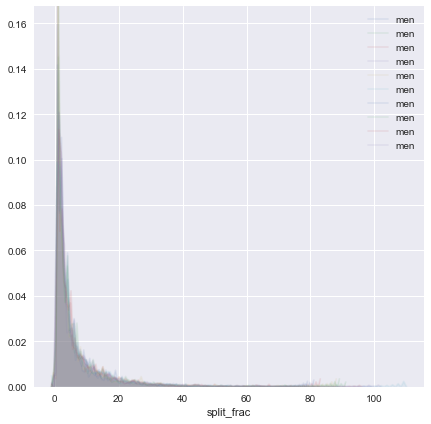

In [255]:
for i in range(runs):
    sns.kdeplot(euclidean['eu'+str(i)], label='men', alpha = 0.1, shade = True)
plt.xlabel('split_frac')

In [ ]:
plt.axvline(0, color="k", linestyle="--");

In [286]:
euclidean.head()

eu0  eu1  eu2  eu3  eu4  eu5  eu6  eu7  eu8  eu9  streetID   eu  \
streetID                                                                    
27          0    0    0    0    0    0    0    0    0    0        27  0.0   
30          4    7    4    2    3    8    3   10    8    4        30  5.3   
31          0    0    0    0    0    0    0    0    0    0        31  0.0   
32          4    7    4    2    3   10    3   10    9    4        32  5.6   
119         0    0    0    0    2    2    0    0    0    0       119  0.4   

                  stdv  
streetID                
27        0.0000000000  
30        2.5709920264  
31        0.0000000000  
32        2.9393876913  
119       0.8000000000

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


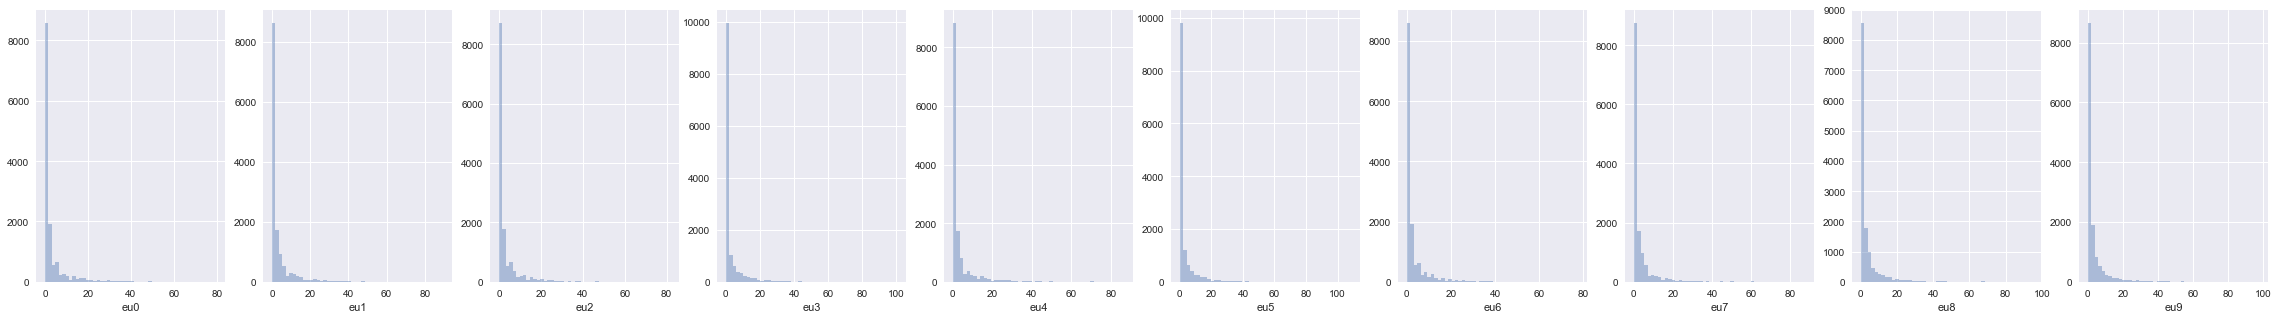

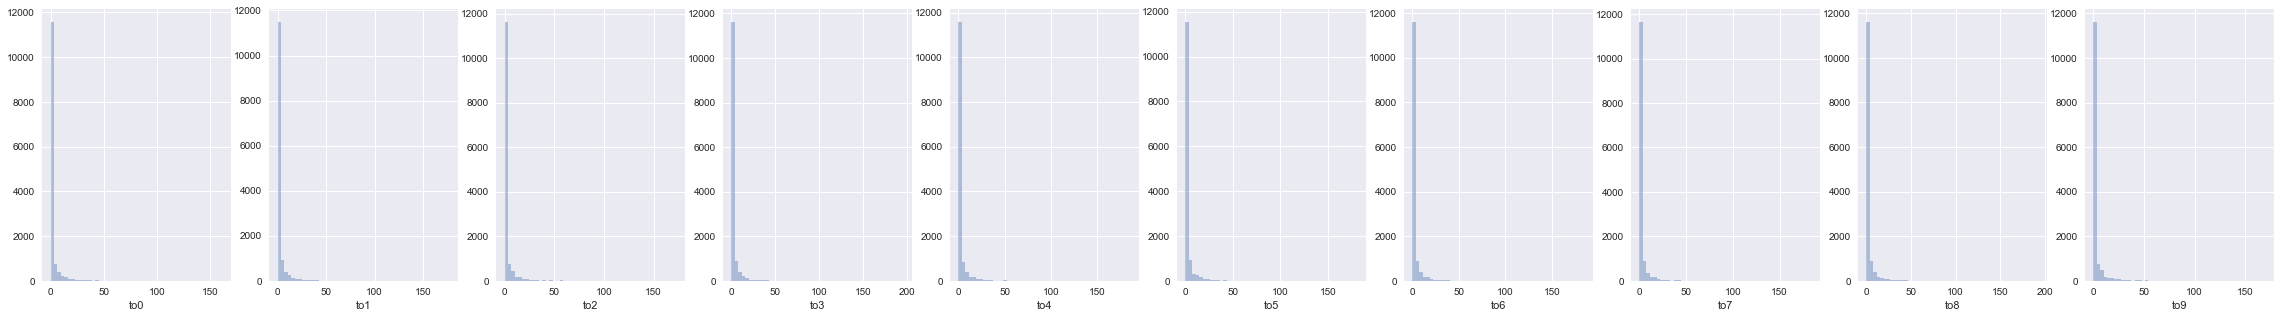

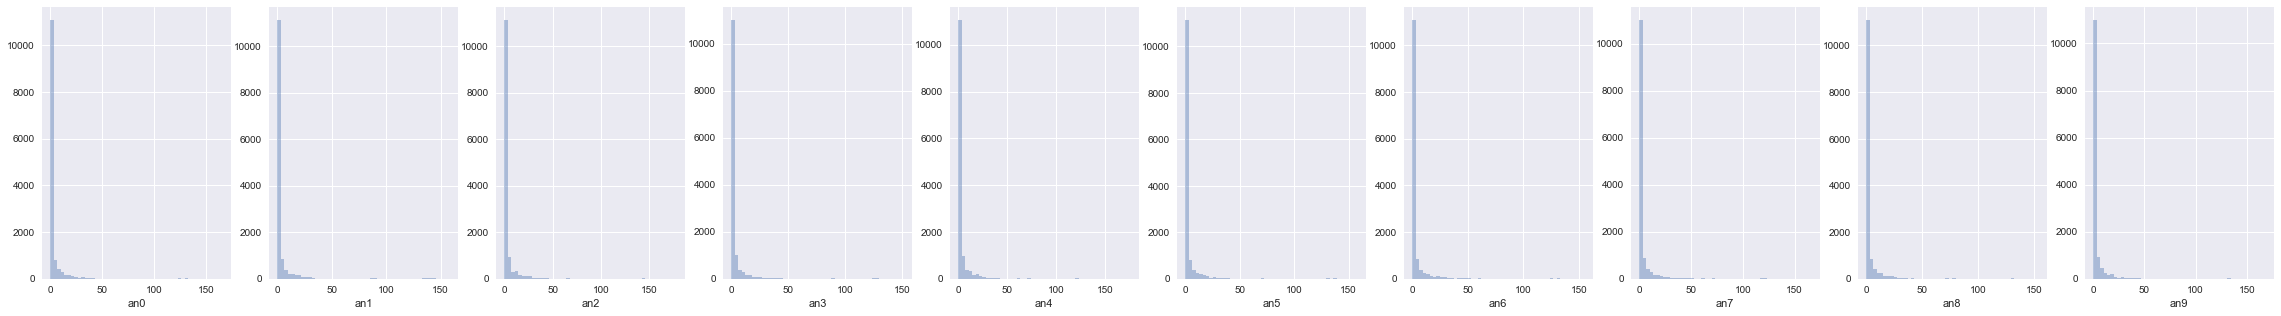

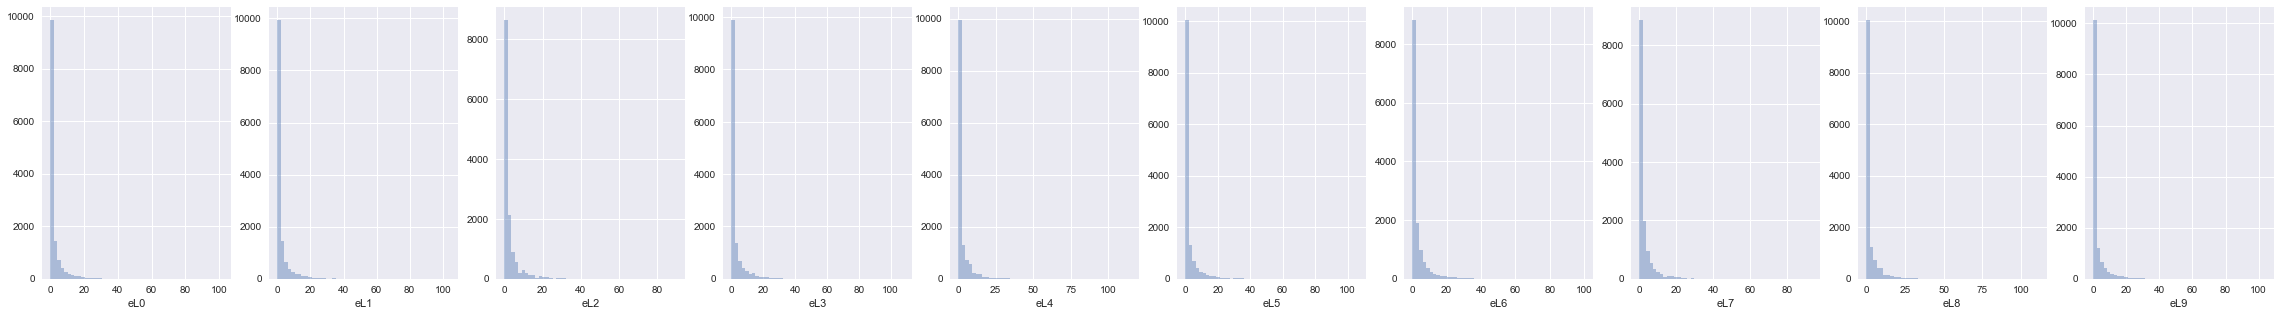

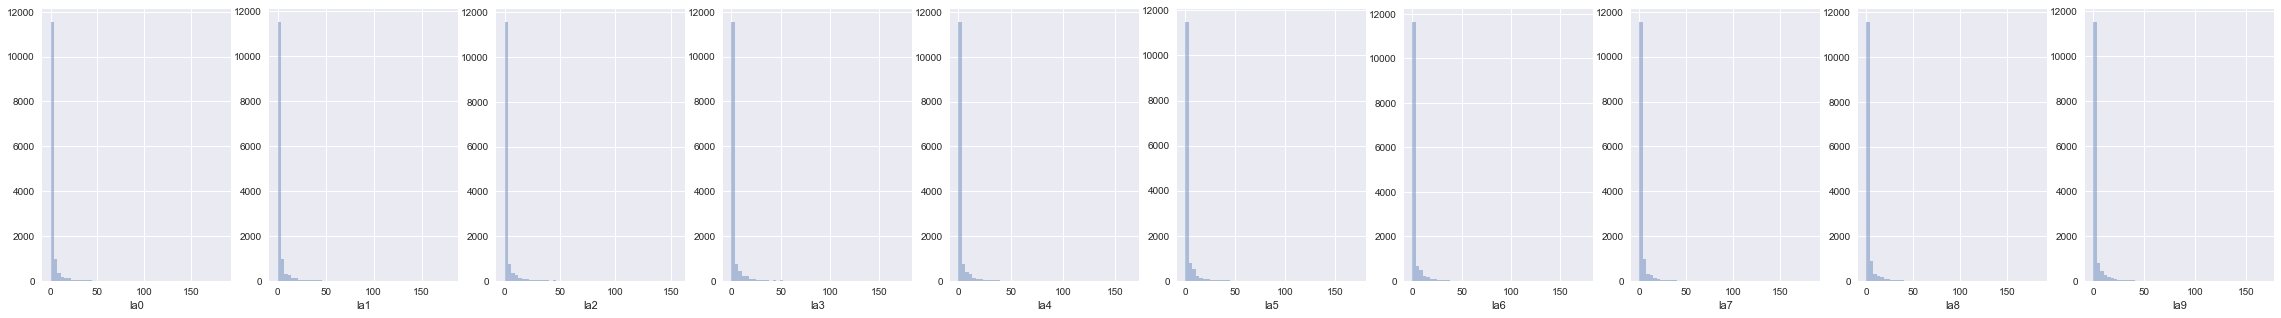

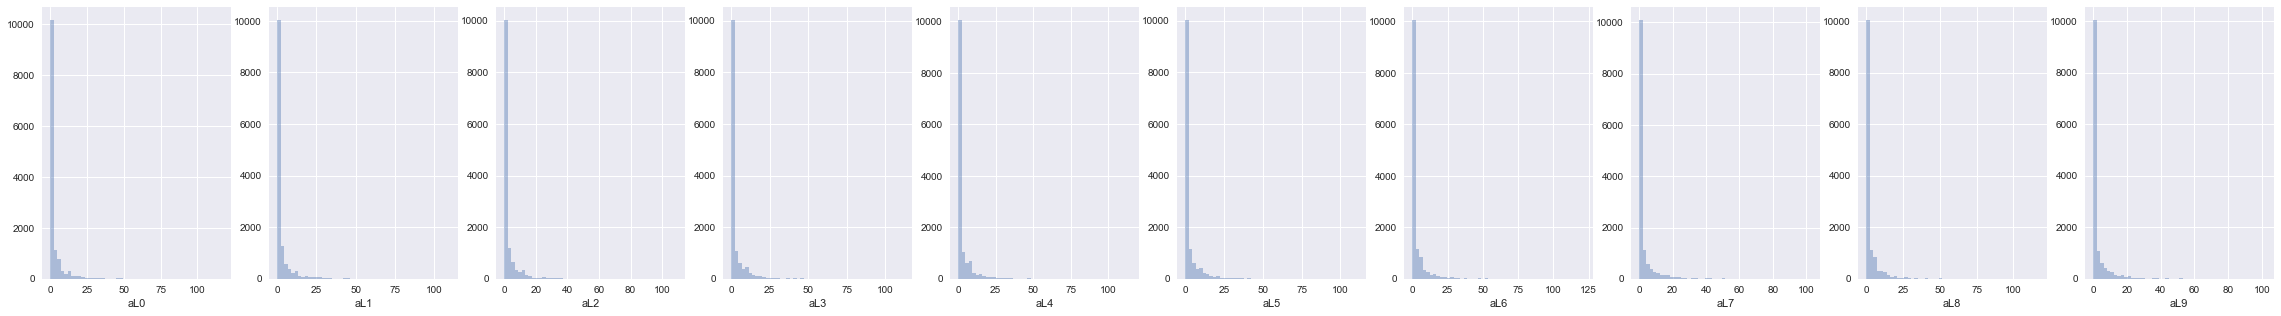

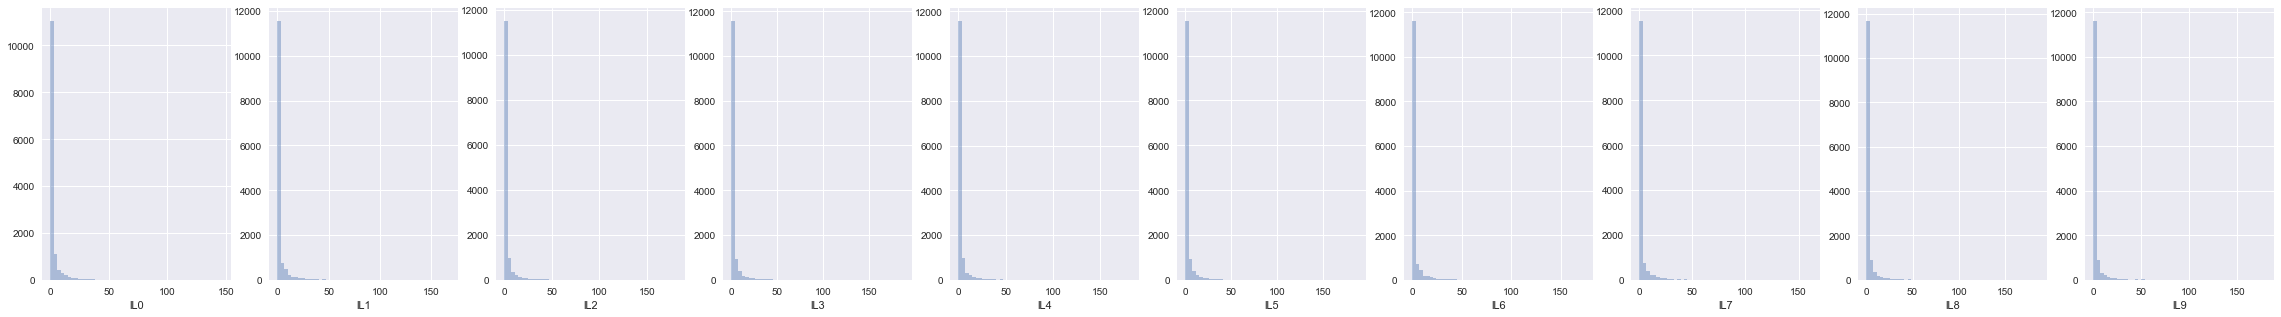

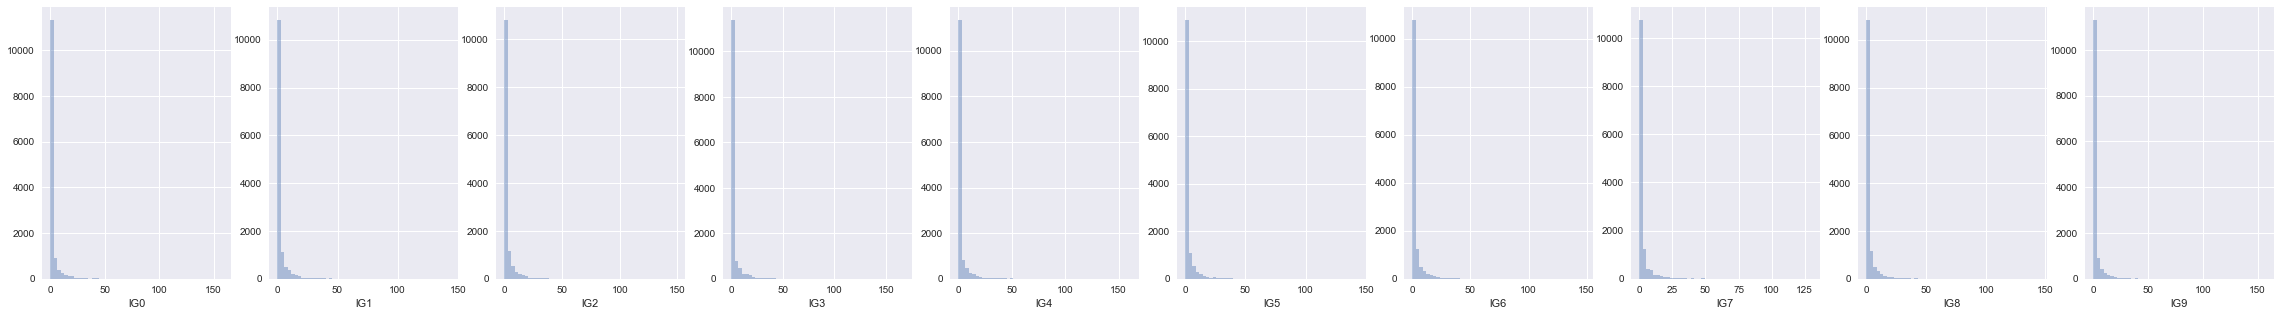

In [311]:
for n, i in enumerate(df_list):
    sns.set(rc={'figure.figsize':(40, 5)})
    fig, axes = plt.subplots(ncols = 10)
    for ax, c in zip(axes, i.columns[0:10]):
        sns.distplot(i[c], ax=ax, rug = False, kde = False, norm_hist= False)

plt.show()

In [323]:
t = True
c = False
if t: print('d')

d


In [322]:
nodes.nodeID.values

array([   11,    43,    44, ..., 17350, 17352, 17353], dtype=int64)

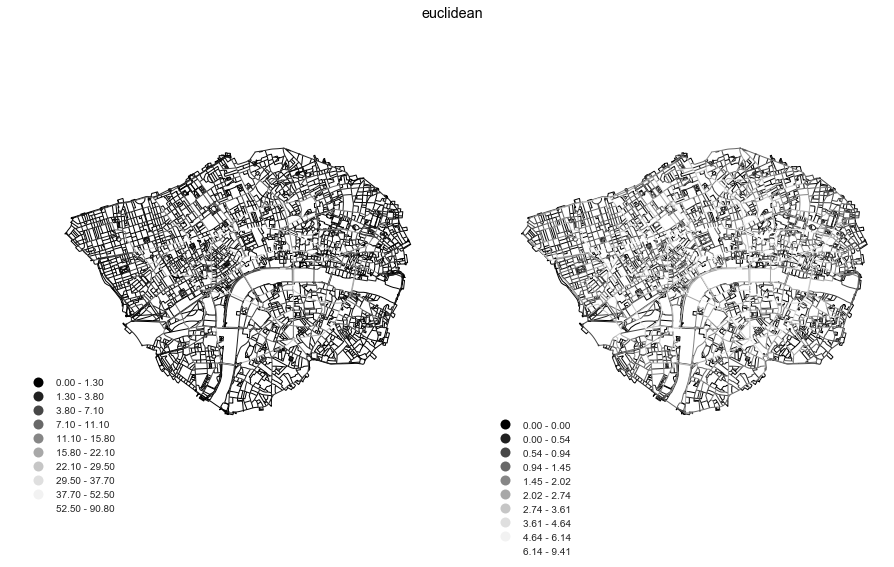

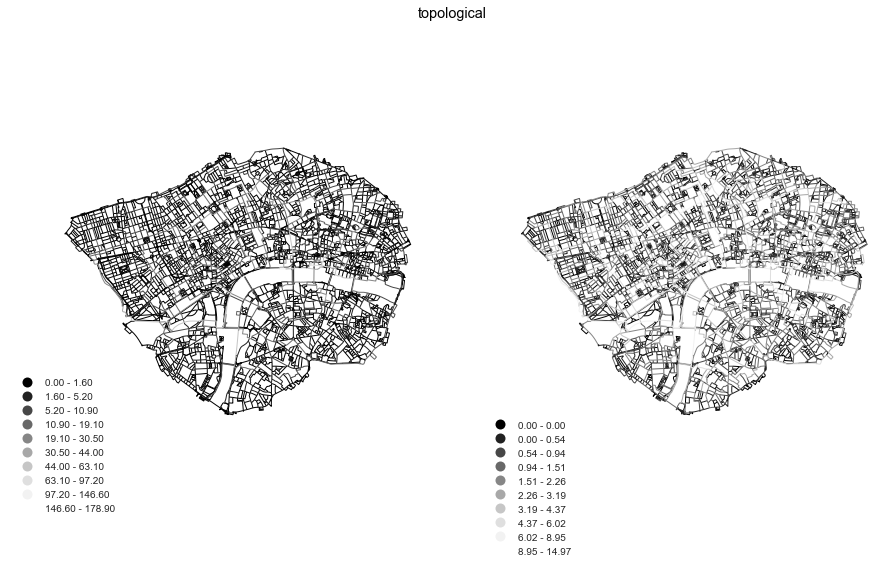

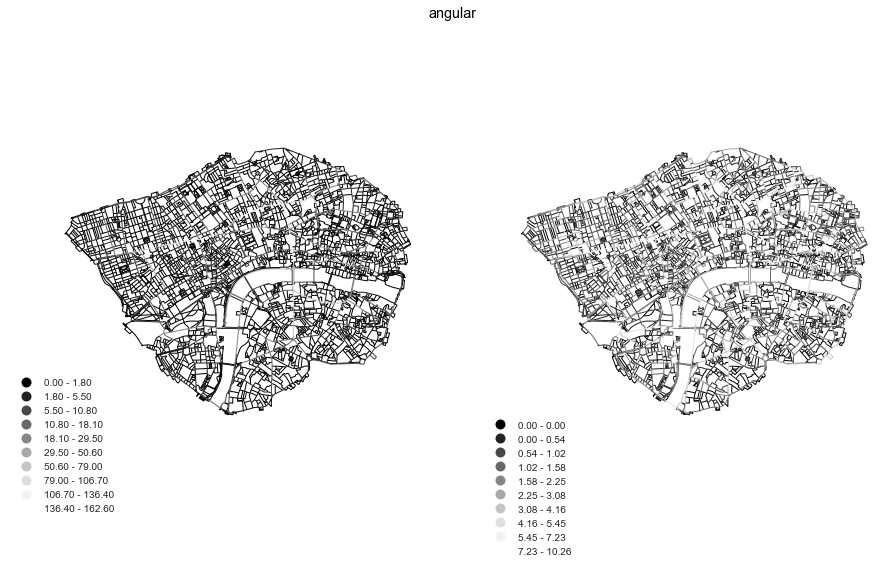

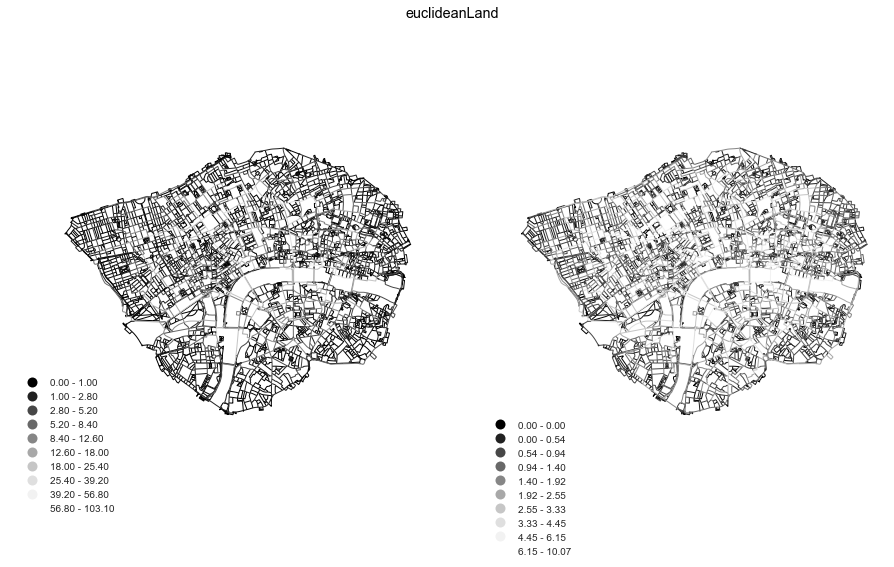

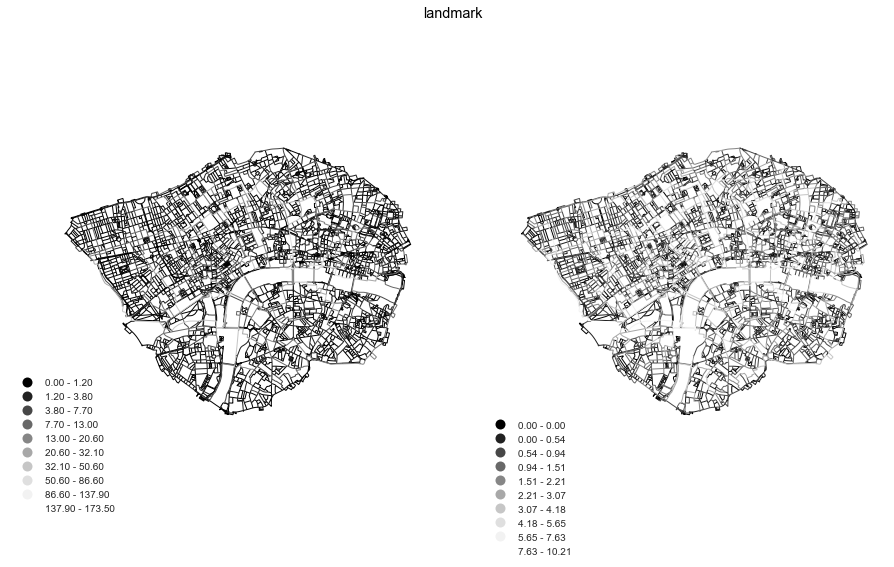

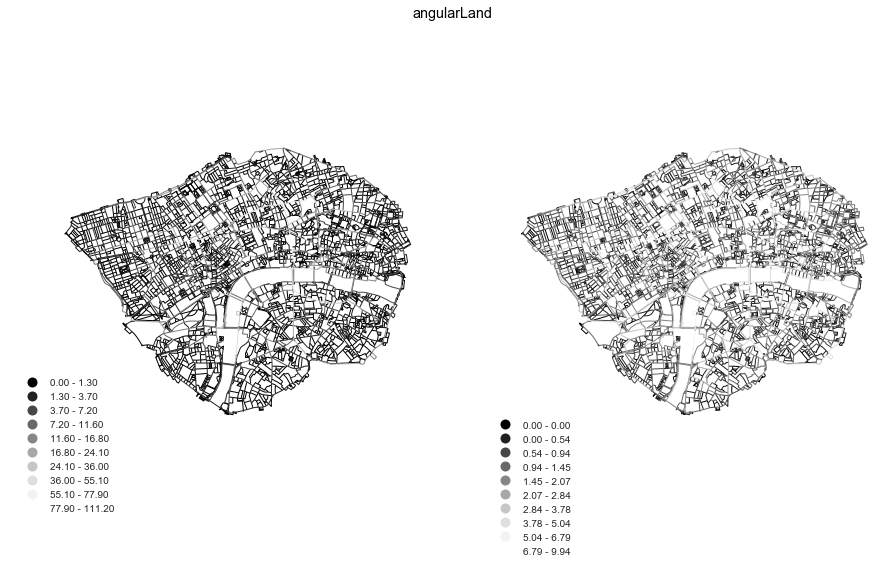

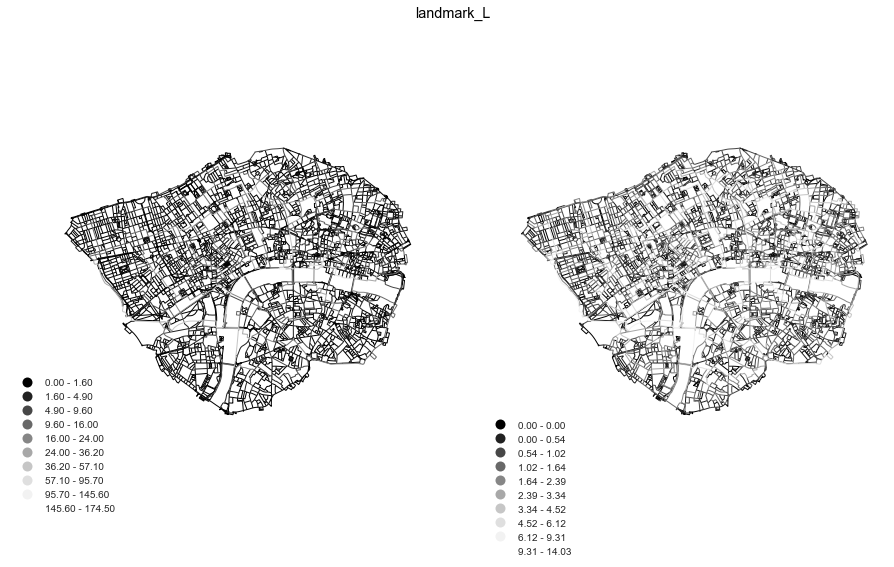

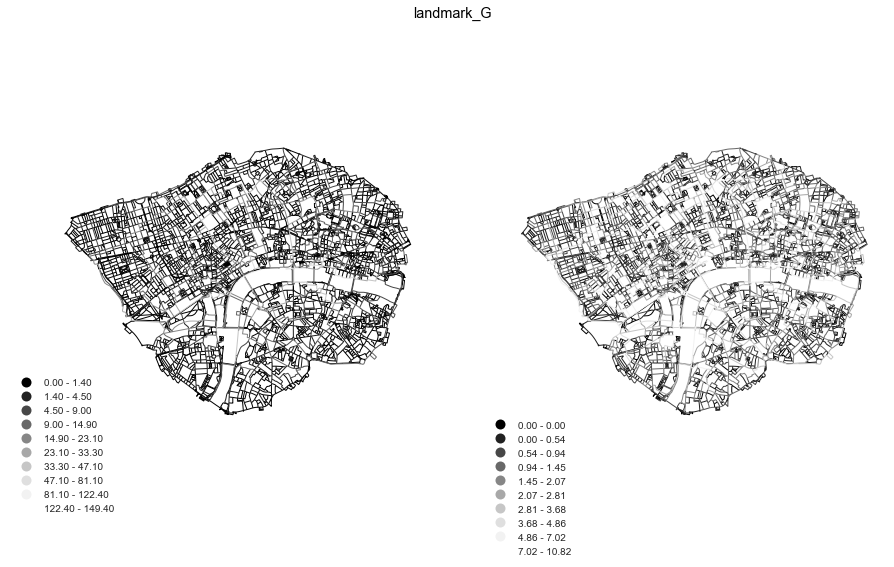

In [324]:
for n, i in enumerate(df_list):
    tmp = pd.merge(paths_data, i, left_on= "streetID", right_on= "streetID", how= 'left')
    uf.plot_lines_aside(tmp, classes = 10, lw = 1, column = col_list[n], column_a =  'stdv', title = col_t[n+1], 
               scheme = 'fisher_jenks', cmap = 'Greys_r', legend = True, black_back = False)

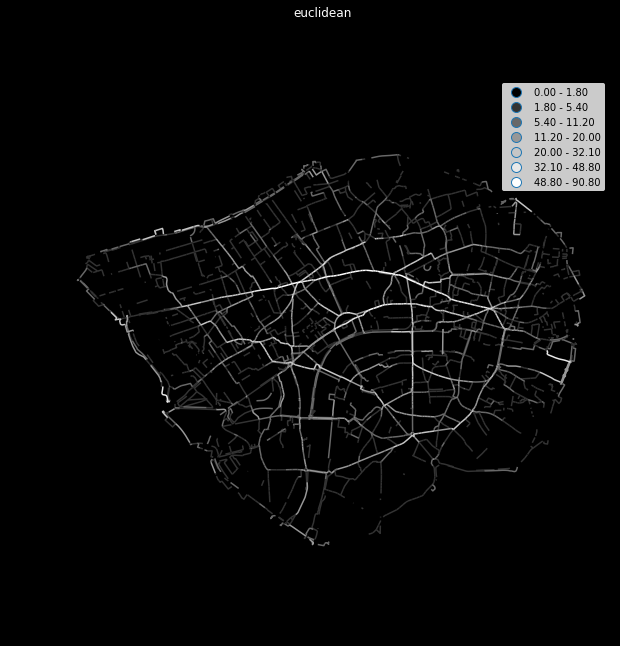

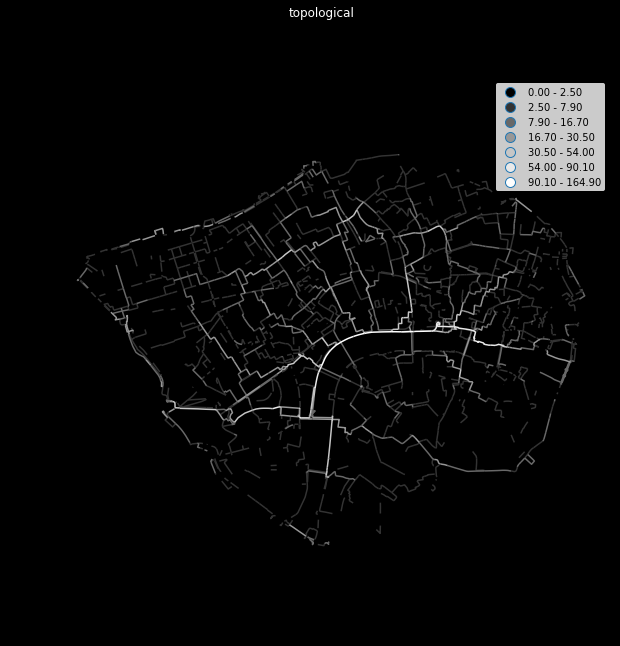

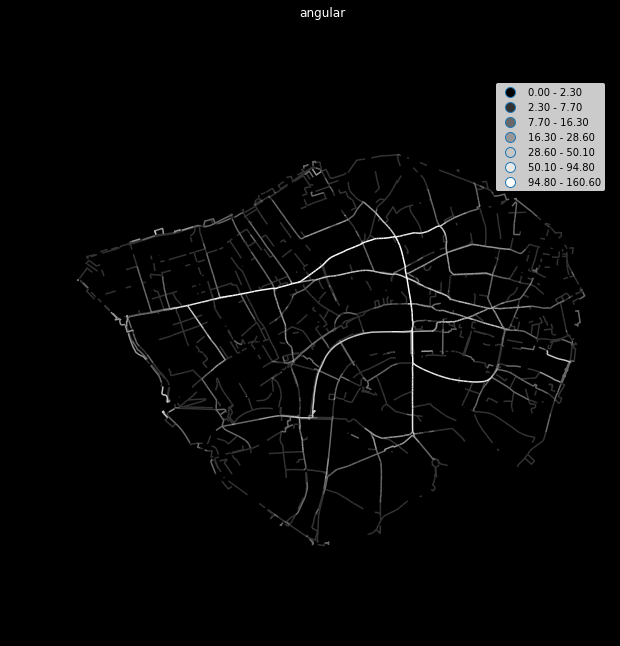

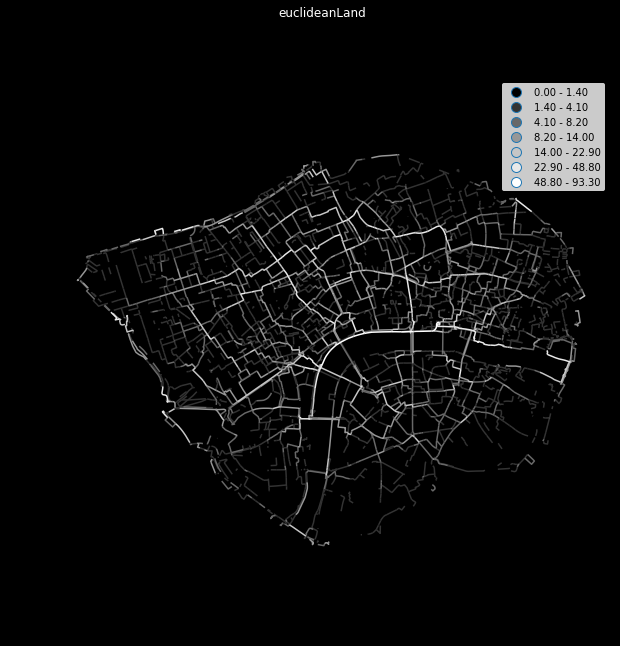

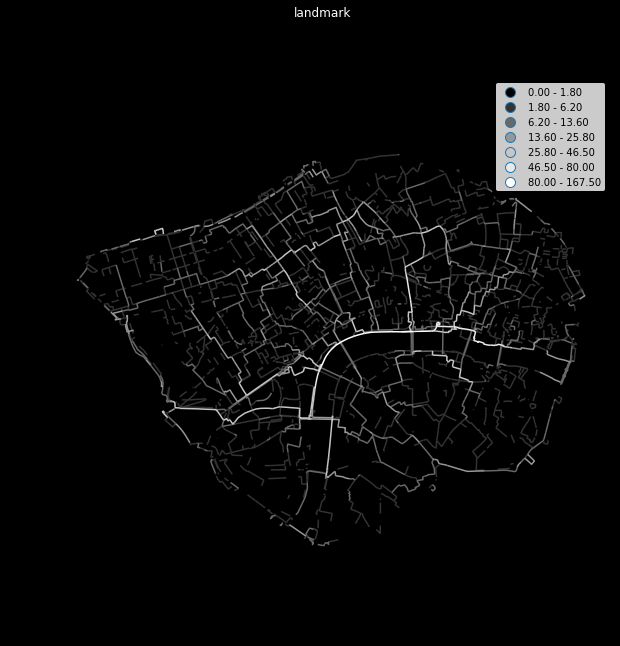

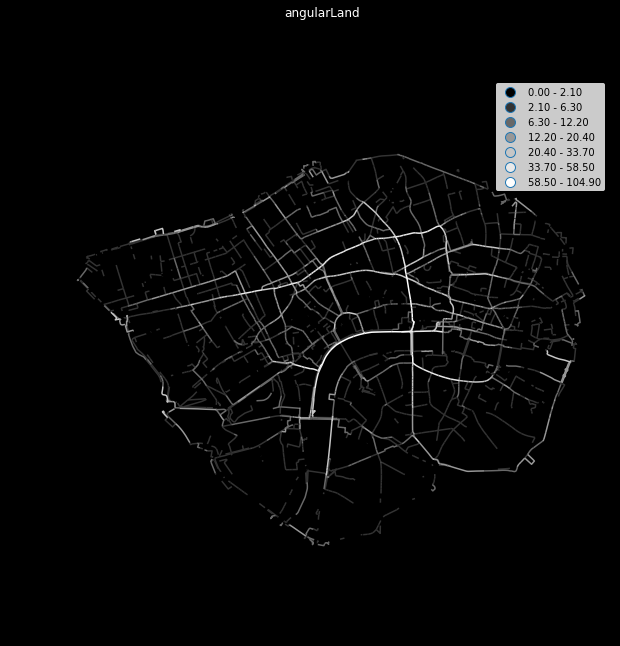

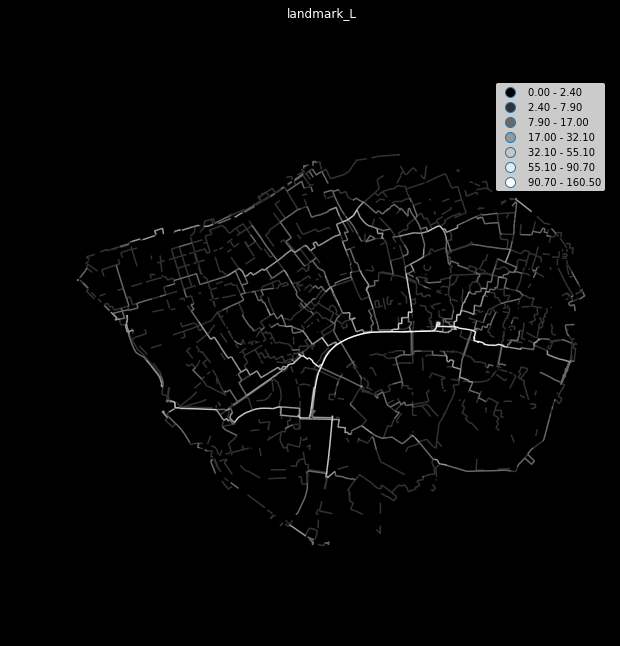

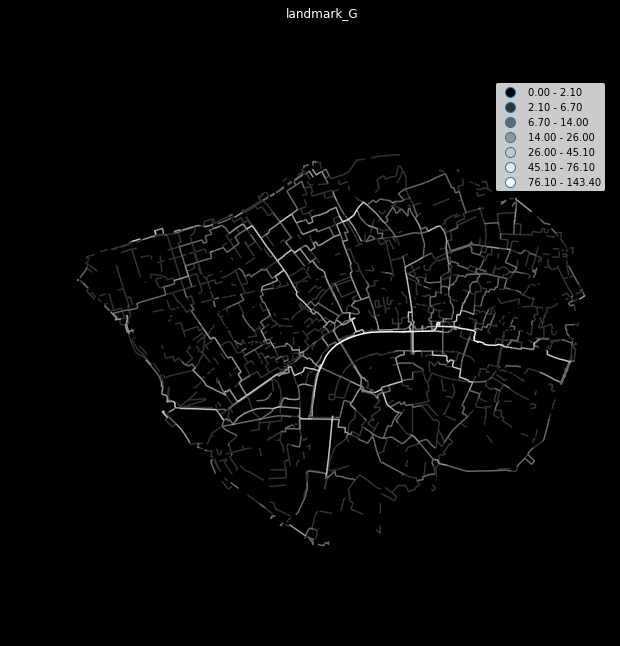

In [155]:


for n,i in enumerate(col):
    tmp = paths_data.copy()
    tmp['diff'] = abs(tmp['counts']-tmp[i])
#     uf.scaling_columnDF(tmp, i)
    uf.plot_lines(tmp, classes = 7, lw = 1.5, column = 'diff', title = i, 
               scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'white', legend = True, black_back = True)

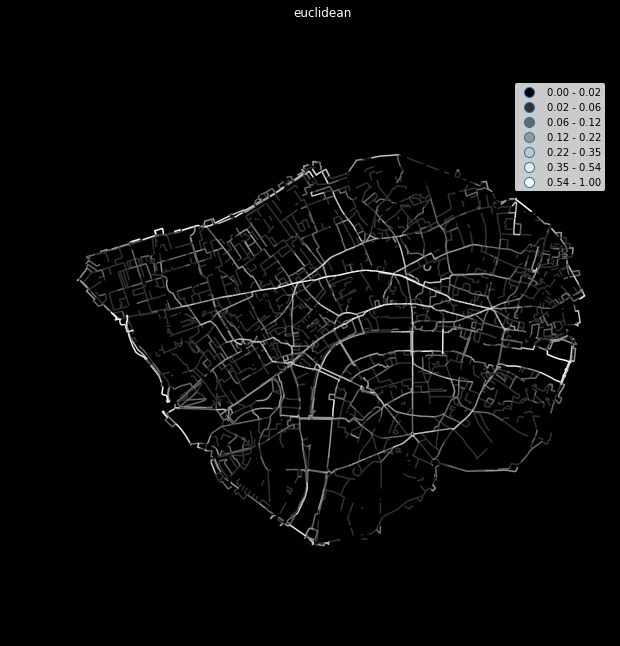

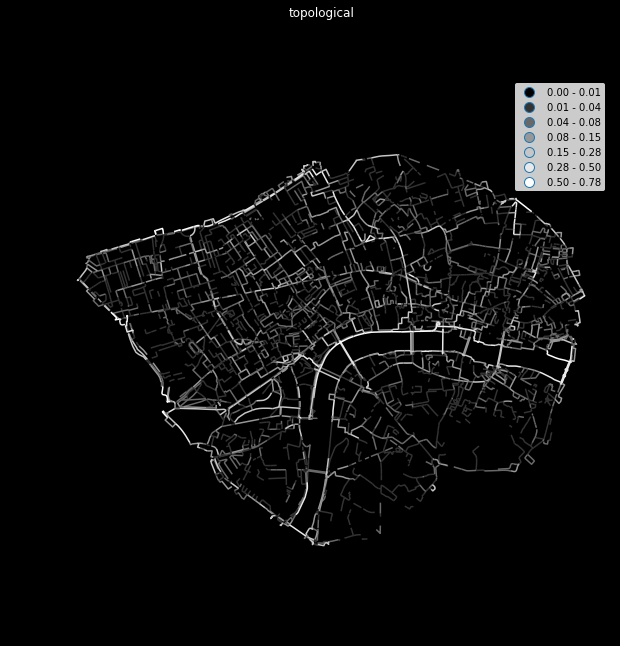

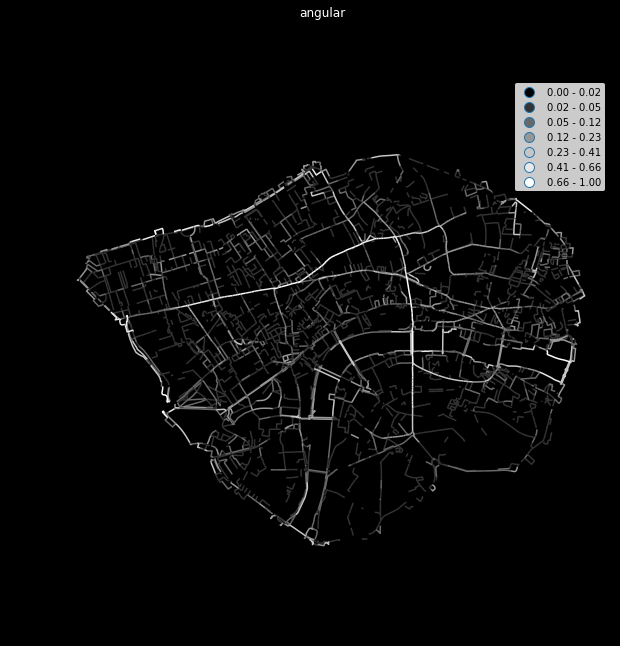

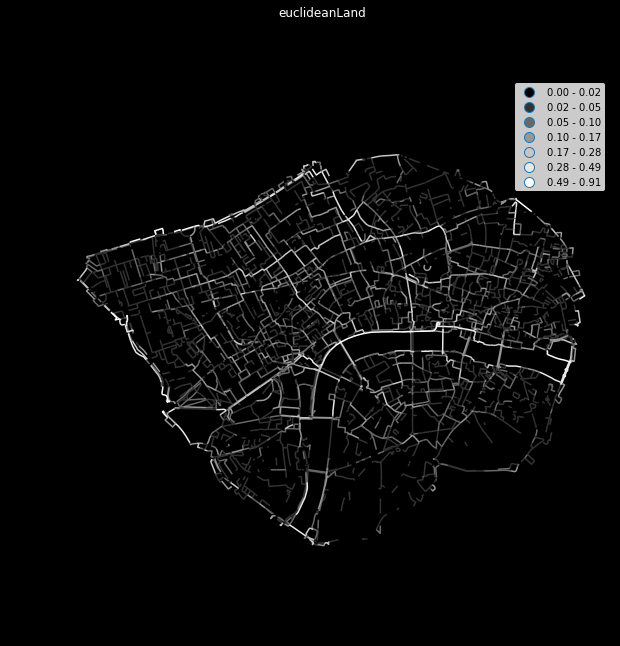

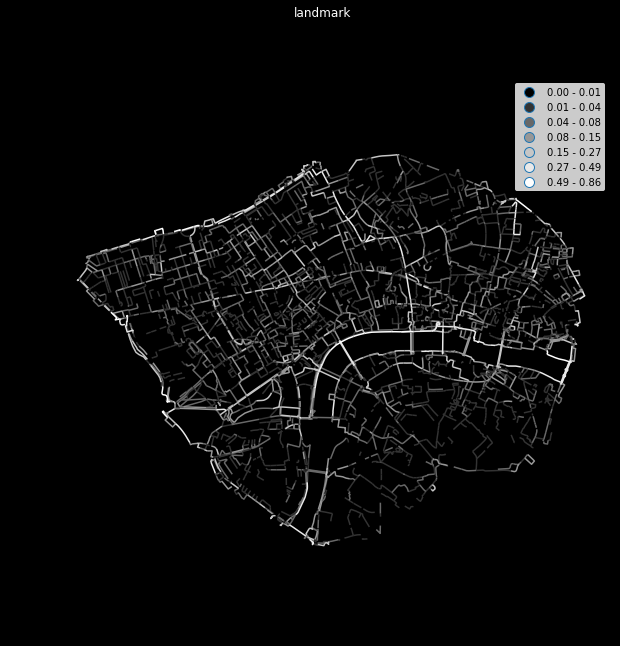

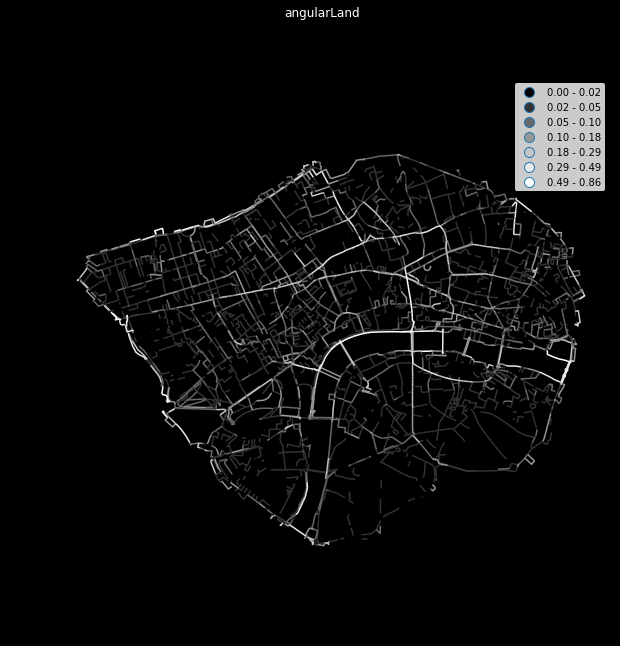

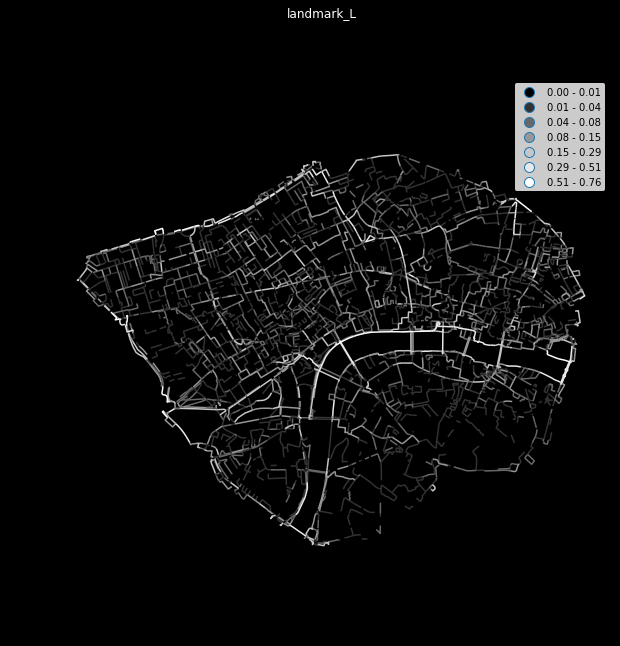

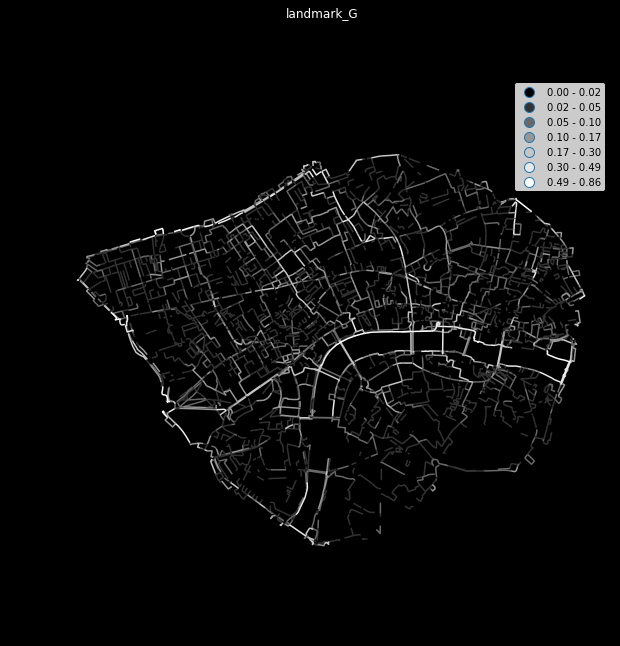

In [159]:
col = ['euclidean', 'topological', 'angular', 'euclideanLand' ,'landmark', 'angularLand', 'landmark_L', 'landmark_G']

for n,i in enumerate(col):
    tmp = paths_data.copy()
    tmp['diff'] = abs(tmp['counts']-tmp[i])
    uf.scaling_columnDF(tmp, i)
    uf.scaling_columnDF(tmp, 'counts')
    tmp['diff'] = abs(tmp['counts_sc']-tmp[i+"_sc"])
    uf.plot_lines(tmp, classes = 7, lw = 1.5, column = 'diff', title = i, 
               scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'white', legend = True, black_back = True)

In [161]:
uf.scaling_columnDF(traj, 'rel_count')
uf.plot_lines(traj, classes = 7, lw = 1.5, column = 'counts', title = 'count', 
               scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'white', legend = True, black_back = True, compare = None)

KeyError: 'angular'

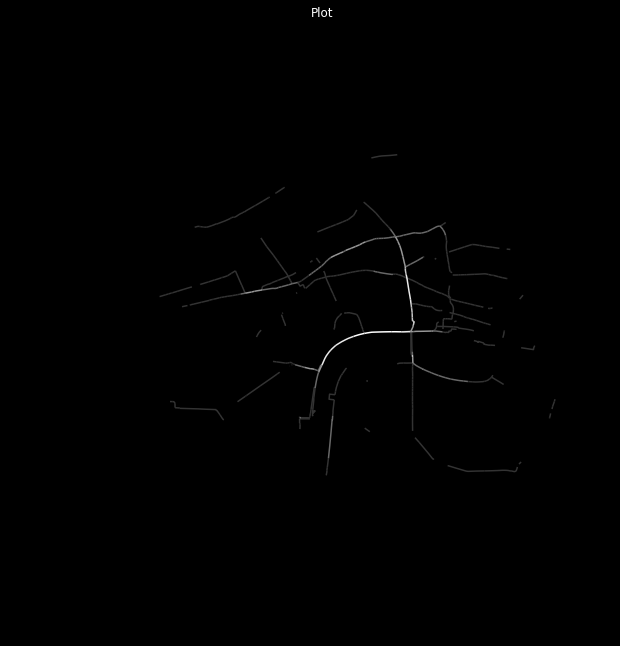

In [149]:
uf.plot_lines(paths_data, classes = 7, lw = 1.5, column = 'angularLand', title = 'Plot', 
               scheme = 'equal_interval', cmap = 'Greys_r', fcolor = 'white', legend = False, black_back = True, compare = None)

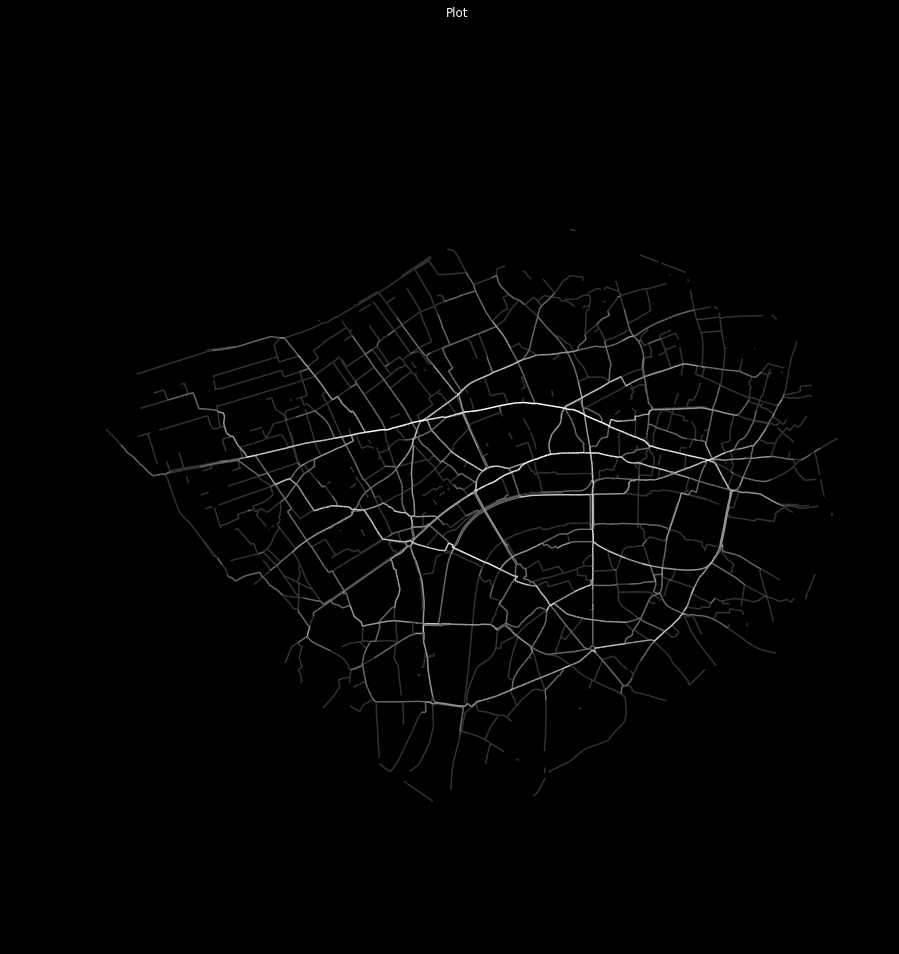

In [250]:
uf.plot_lines(paths_data, classes = 7, lw = 1.5, column = 'euclidean', title = 'Plot', 
               scheme = 'fisher_jenks', cmap = 'Greys_r', fcolor = 'white', legend = False, black_back = True, compare = None)

In [28]:
len(paths_data)

13531

In [ ]:

    
    
    if column != None: gdf.sort_values(by = column, ascending = True, inplace = True)
    f, ax = plt.subplots(1, figsize=(15, 15), facecolor = fcolor)
    if black_back == True: tcolor = 'white'
    else: tcolor = 'black'
    rect = f.patch    
    if black_back == True: rect.set_facecolor('black')
    else: rect.set_facecolor('white')
        
    f.suptitle(title, color = tcolor) 
    plt.axis('equal')
    ax.set_axis_off()
    
    if (column != None) & (scheme == None):
        gdf.plot(ax = ax, column = column, linewidth = lw, legend = legend) 
    
    elif scheme == "LynchBreaks":
        bins = [0.12, 0.25, 0.50, 0.75, 1.00]
        cl = ps.User_Defined(edges_gdf[column], bins)
        gdf.assign(cl = cl.yb).plot(ax = ax, column= 'cl', categorical = True, k = 5, cmap = cmap, linewidth = lw, legend=True)
    
        leg = ax.get_legend()
        leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
        leg.get_texts()[0].set_text('0.00 - 0.12')
        leg.get_texts()[1].set_text('0.12 - 0.25')
        leg.get_texts()[2].set_text('0.25 - 0.50')
        leg.get_texts()[3].set_text('0.50 - 0.75')
        leg.get_texts()[4].set_text('0.75 - 1.00')
    
    elif scheme != None:
        gdf.plot(ax = ax, column = column, k = classes, cmap = cmap, linewidth = lw, scheme = scheme, legend = legend)
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = gdf[column].min(), vmax = gdf[column].max()))
        if legend == True:
            leg = ax.get_legend()  
            leg.get_frame().set_linewidth(0.0)
        
#         sm._A = []
#         cb=plt.colorbar()
#         f.colorbar(sm)
        
    else:
        gdf.plot(ax = ax, linewidth = lw, color = 'black')
        if compare != None: compare.plot(ax = ax, linewidth = 1, color = 'red')  
    
     
    plt.show()

In [24]:
paths_data.to_file(folder_ouptut+city_name+'_pedestrians_count.shp', driver='ESRI Shapefile')

In [ ]:
paths_data.dtypes

In [ ]:
cmap = cm.get_cmap('Greys_r')
cmap(100)

In [ ]:
paths_data['euclideanDiff'] = paths_data['euclidean']-paths_data['euclideanLand']

In [41]:
paths_data.dtypes

streetID           int64
length           float64
highway           object
name              object
v                  int64
u                  int64
key                int64
Eb               float64
Erw              float64
Ab               float64
natural_id        object
length_sc        float64
geometry          object
euclidean          int64
topological        int64
angular            int64
euclideanLand      int64
landmark           int64
angularLand        int64
landmark_L         int64
landmark_G         int64
offset            object
dtype: object

In [43]:
df = paths_data.drop(['geometry', 'offset'], axis=1).copy()
crs = crs
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=paths_data.offset)

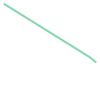

In [71]:
paths_data.loc[1407].geometry

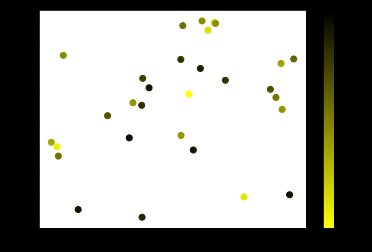

In [141]:
import numpy as np
import matplotlib.pyplot as plt


norm=plt.Normalize(-2,2)
plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [154]:
yell = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","black"])

TypeError: 'LinearSegmentedColormap' object does not support indexing

In [215]:
cl = ps.Fisher_Jenks(gdf["euclidean"], 7)
cmap = cm.get_cmap('gist_heat') 
cmap(7)

(0.041176470588235294, 0.0, 0.0, 1.0)

In [41]:
from shapely.affinity import translate

7
(0.91666174462696193, 0.0, 0.0, 1.0)
(1.0, 0.35416704947854455, 0.0, 1.0)
(1.0, 0.79166633854219981, 0.0, 1.0)
(1.0, 1.0, 0.34374934374934368, 1.0)
(1.0, 1.0, 1.0, 1.0)


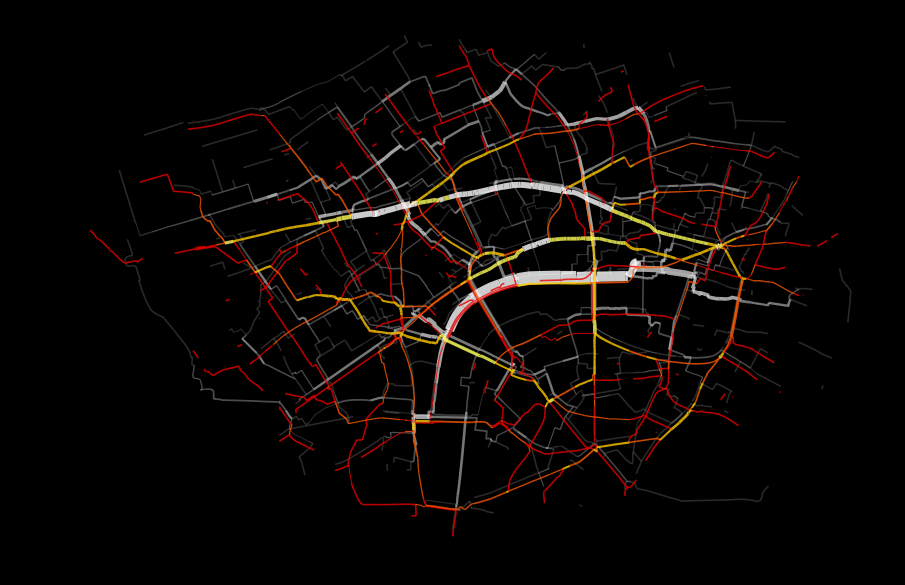

In [44]:
import matplotlib.colors
yell = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "yellow"])

def ss_grad_GDF(gdf, column, column2, title, black_back, cmap = 'Greys_r', save = False, directory = None):
    
#     gdf.sort_values(by = column, ascending = True, inplace = True)
    f, ax = plt.subplots(1, figsize=(15, 15))
    if black_back == True: tcolor = 'white'
    else: tcolor = 'black'
    rect = f.patch    
    if black_back == True: rect.set_facecolor('black')
    else: rect.set_facecolor('white')

    cl = ps.Fisher_Jenks(gdf[column], 7)
    tmp = gdf.assign(cl = cl.yb)
    cmap = cm.get_cmap('Greys_r', len(cl.bins)) 
    tmp = gdf.assign(cl = cl.yb)
#     lw = gdf[column]*3/1000
    lw = 2.5
#     gdf.assign(cl=cl.yb).plot(ax=ax, column='cl', categorical=True, k=8, cmap=cmap, linewidth=lw, legend=False)
    
    for i in range(0, len(cl.bins)):
        tmp_p = tmp[tmp.cl == i]
        lw = tmp_p[column]*4/1000
        lw = [1.6 if x < 1 else x for x in lw]
        if i <2: continue
        if i == len(cl.bins): alpha = 1
        else: alpha = i/10+0.20
        
        tmp_p.plot(ax=ax, color = cmap(i), categorical=True, 
                   linewidth = lw, legend=False, alpha = alpha)

    geo = gdf['geometry'].apply(lambda x: translate(x, xoff=0, yoff=-50))
    df = gdf.drop(['geometry'], axis=1).copy()
    crs = gdf.crs
    gdf2 = gpd.GeoDataFrame(df, crs=crs, geometry = geo) 
    
#     gdf2.sort_values(by = column2, ascending = True, inplace = True)
    cl = ps.Fisher_Jenks(gdf2[column2], 7)
    cmap = cm.get_cmap('hot', len(cl.bins)) 
    tmp = gdf2.assign(cl = cl.yb)

#     linewidth = gdf2[column2]*3/1000
    uf.scaling_columnDF(gdf2, column2, inverse = False)
#     alpha = gdf2[column2+"_sc"]
#     gdf2.assign(cl=cl.yb).plot(ax=ax, column='cl', categorical=True, k=7, cmap=cmap, linewidth=lw, alpha = 0.8, legend=True)
    
    print(len(cl.bins))
    for i in range(0, len(cl.bins)):
        tmp_p = tmp[tmp.cl == i]
        lw = tmp_p[column2]*3/1000
        lw = [1.6 if x < 1 else x for x in lw]
        if i <2: continue
#         if i == 0: alpha = 0
#         elif i == len(cl.bins): alpha = 1
#         else: alpha = i/10+0.20
        color = cmap(i)
        print(color)
        tmp_p.plot(ax=ax, color = color, categorical = True, linewidth = lw, alpha = alpha, legend=False )    

    ax.set_axis_off() 
    plt.axis('scaled')
    plt.show()

ss_grad_GDF(paths_data, "euclideanLand","euclidean", "--", black_back = True, save = True)

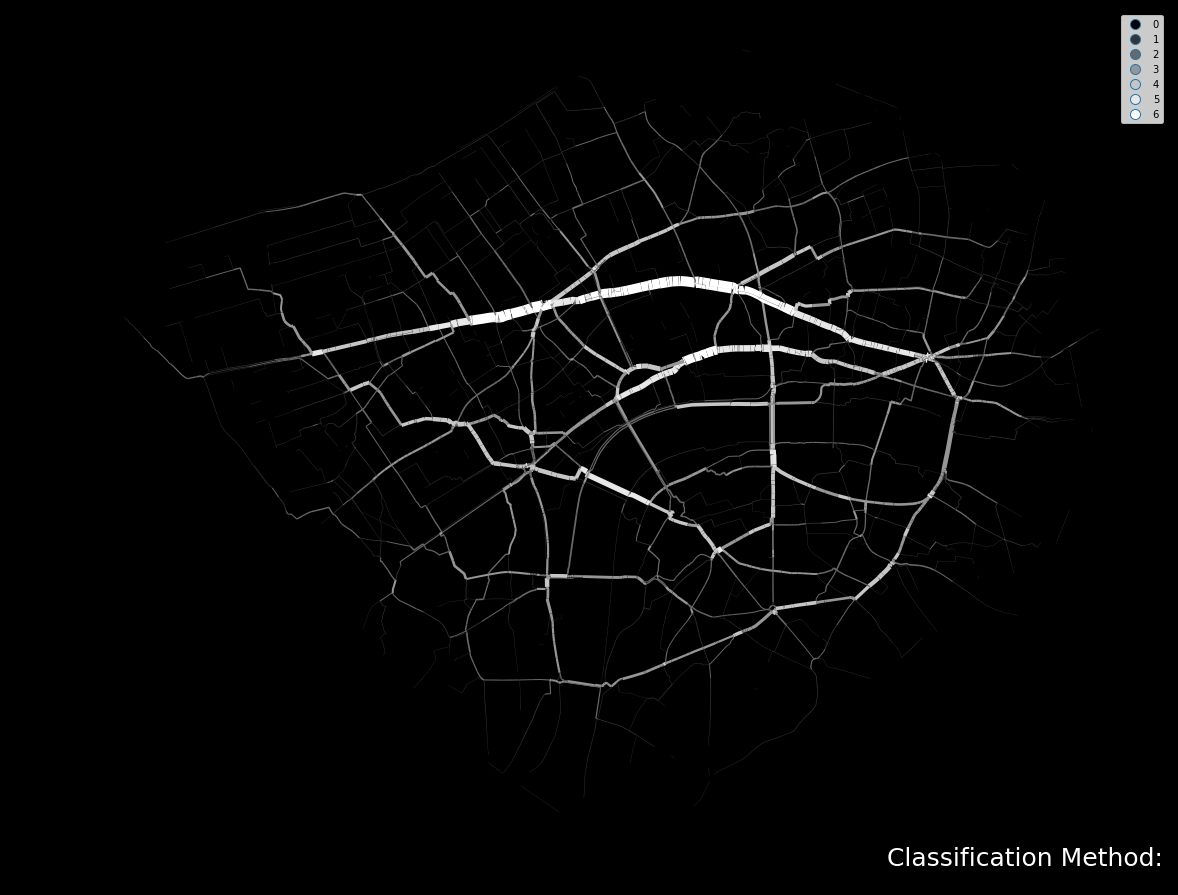

In [35]:
def ttF(gdf, column, title, black_back = True, cmap = 'Greys_r', save = False, directory = None):
    
#     cmap = cm.get_cmap('Greys_r', 7) 

    f, ax = plt.subplots(figsize=(20, 20)) 
    if black_back == True: tcolor = 'white'
    else: tcolor = 'black'
    rect = f.patch    
    if black_back == True: rect.set_facecolor('black')
    else: rect.set_facecolor('white')
    

    cl = ps.Fisher_Jenks(gdf[column], 7)
    tmp = gdf.assign(cl = cl.yb)
    cmap = cm.get_cmap('Greys_r', len(cl.bins)) 
    
#     bins = [50, 100, 200, 400, 800, 1600, 3200, 5000]
#     cl = ps.User_Defined(gdf[column], bins)
#     cmap = cm.get_cmap('Greys_r', len(cl.bins))
    tmp = gdf.assign(cl = cl.yb)
    
    lw = gdf[column]*5/1000
    gdf.assign(cl=cl.yb).plot(ax=ax, column='cl', categorical=True, k=8, cmap=cmap, 
                              linewidth=lw, legend=True)       
   
    smallprint = ax.text(
    .995, 0,
    'Classification Method:',
    ha='right', va='bottom',
    size=25,
    color='white',
    transform=ax.transAxes)
    
    

#     f.suptitle(title)

    ax.set_axis_off() 
    plt.axis('scaled')
    if black_back == True: plt.rcParams['figure.facecolor'] = 'black'
    else: plt.rcParams['figure.facecolor'] = 'white'     
        
    plt.rcParams['figure.facecolor'] = 'black'

    plt.show()


el = ttF(paths_data,"euclidean","euclideanLand", black_back = True, save = True)

In [ ]:
#     leg = ax.get_legend()

# #     leg.set_title(title)
#     leg.get_title().set_fontsize(30)
#     leg.get_title().set_color('white')
#     plt.setp(ax.get_legend().get_texts(), fontsize=20, color = 'white')
    
#     leg.set_frame_on(True)
#     frame = leg.get_frame()
#     frame.set_facecolor('black')
# #     frame.set_alpha(0.9)
#     leg.set_bbox_to_anchor((1.20, 0.65))
#     leg.get_frame().set_linewidth(0.0)
    
#     for l in leg.get_lines():
#         l._legmarker.set_marker('_')
#         l._legmarker.set_markersize(20)
#         l._legmarker.set_linestyle('-')
#         l._legmarker.set_markeredgewidth(6)
#         l._legmarker.set_markeredgecolor(l.get_markerfacecolor())
    
#     leg.handletextpad = 1.5
#     if save == True: f.savefig(directory+title+'.png', format='png',  dpi=500) 
#     return(plt)

In [ ]:
paths_data.head()

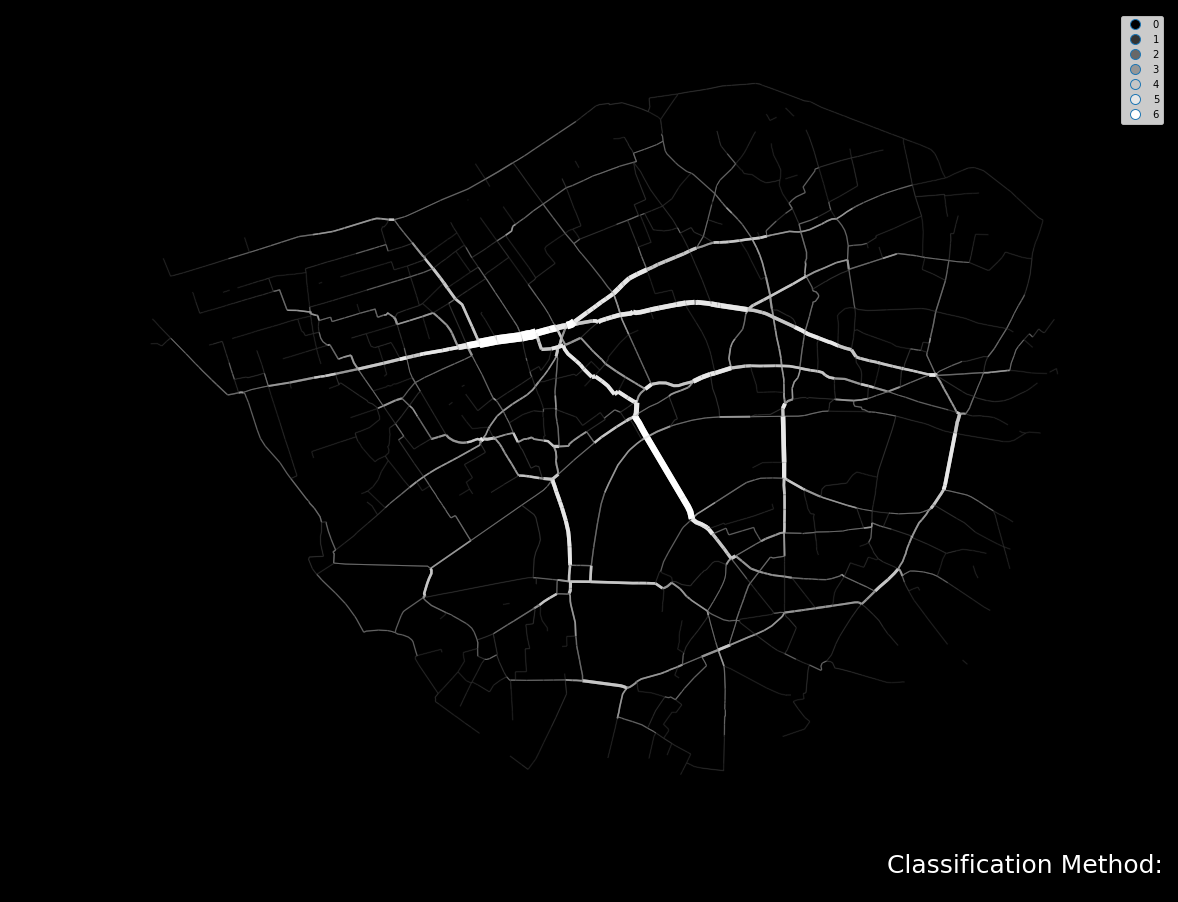

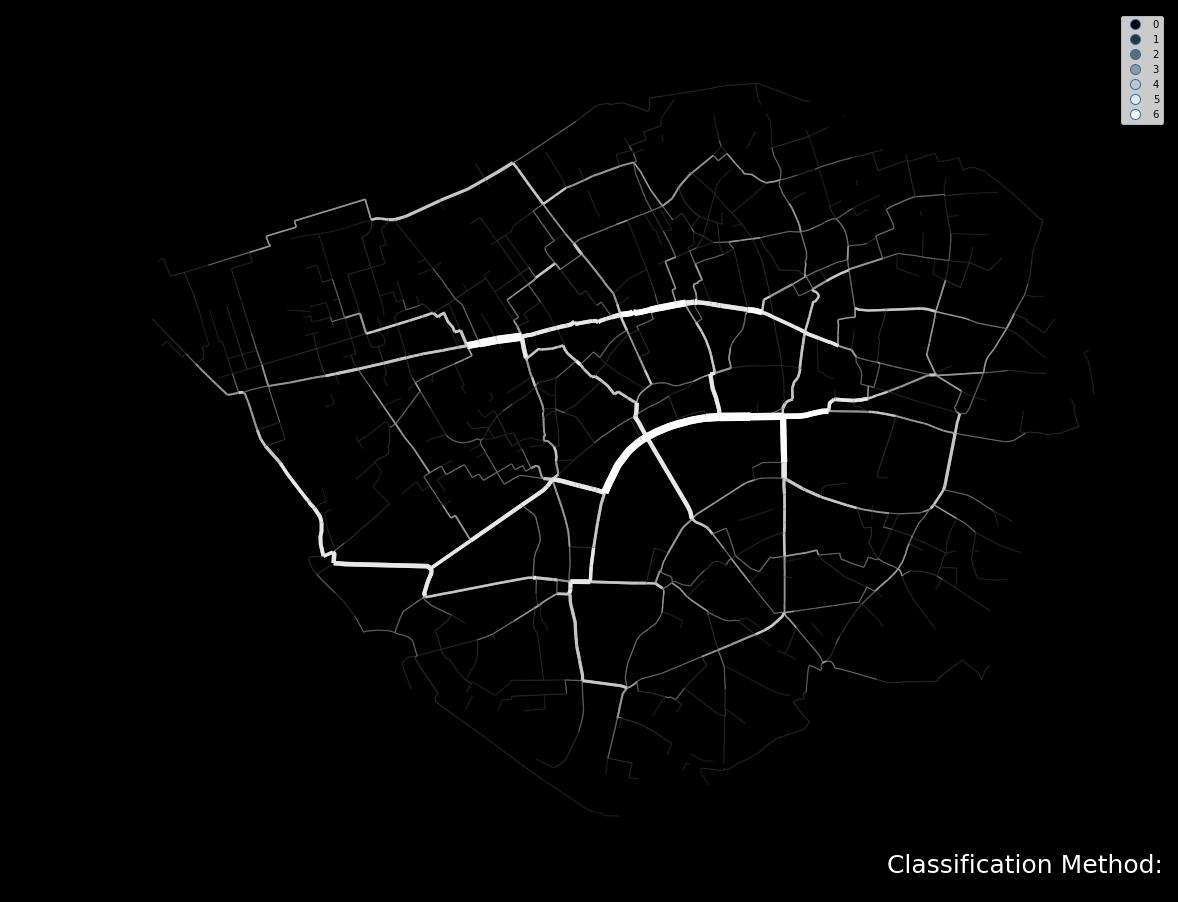

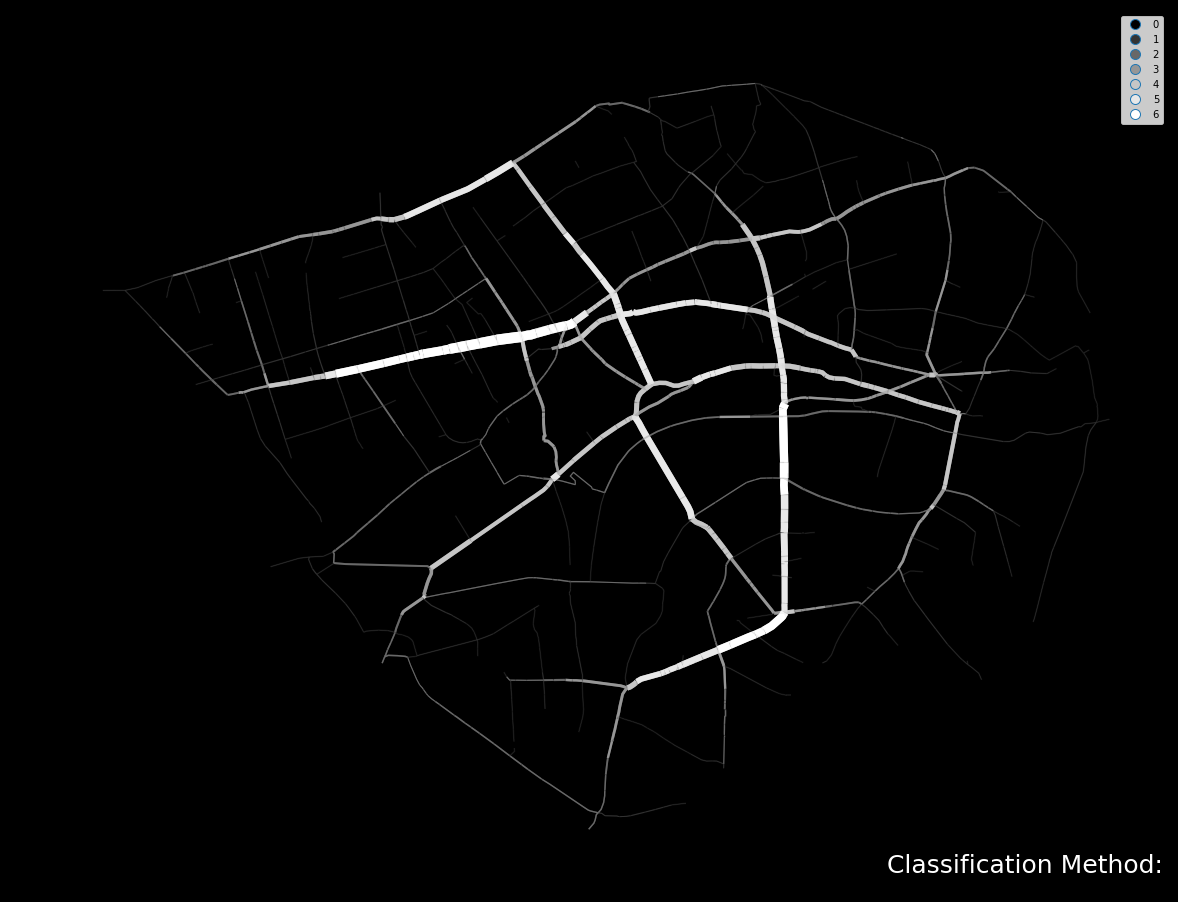

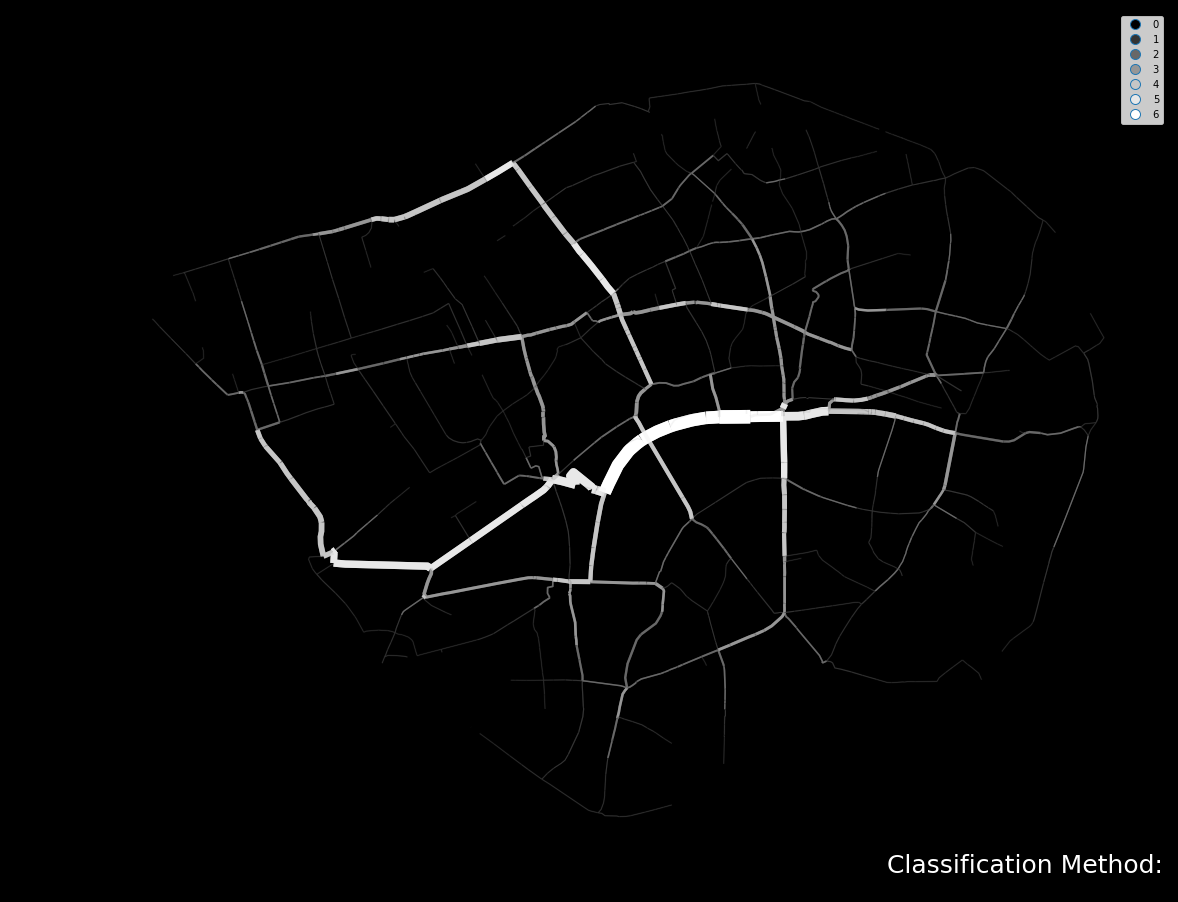

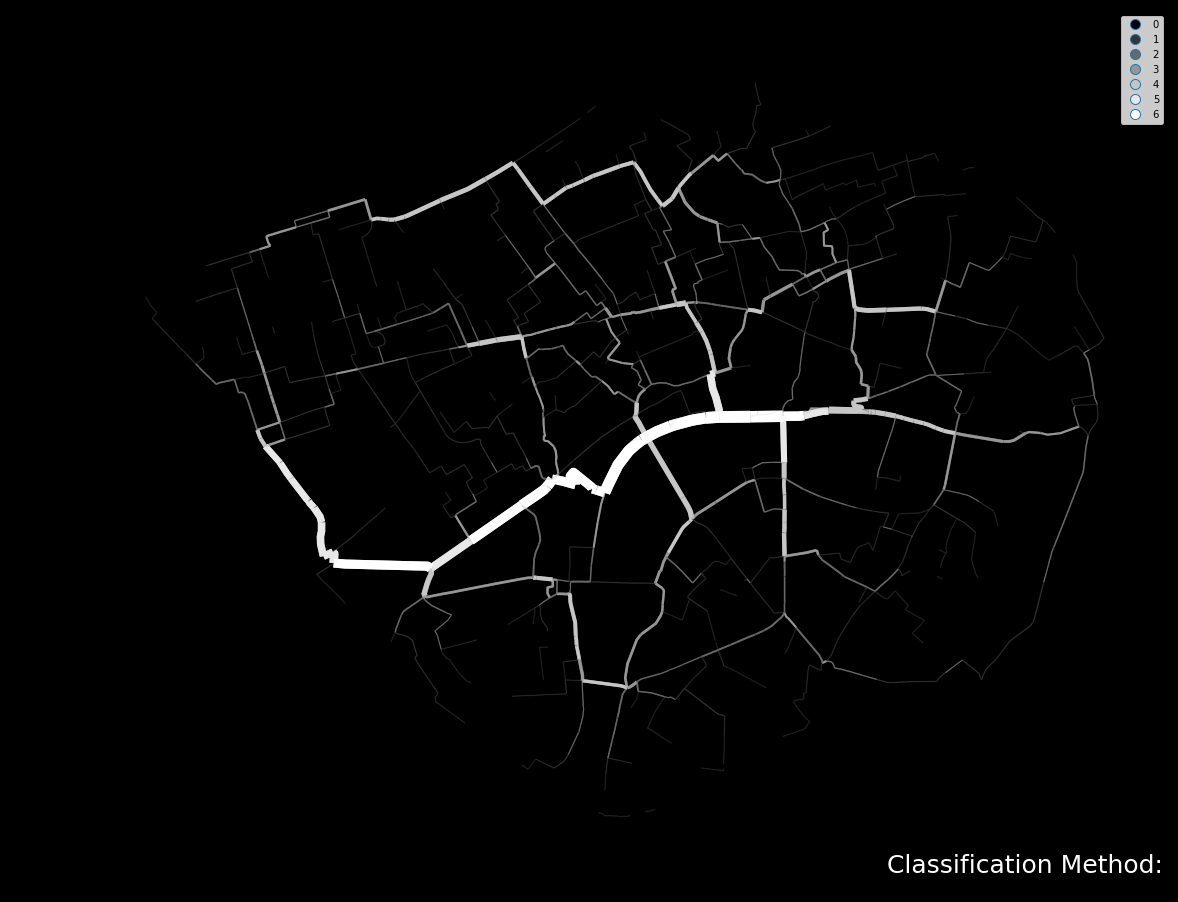

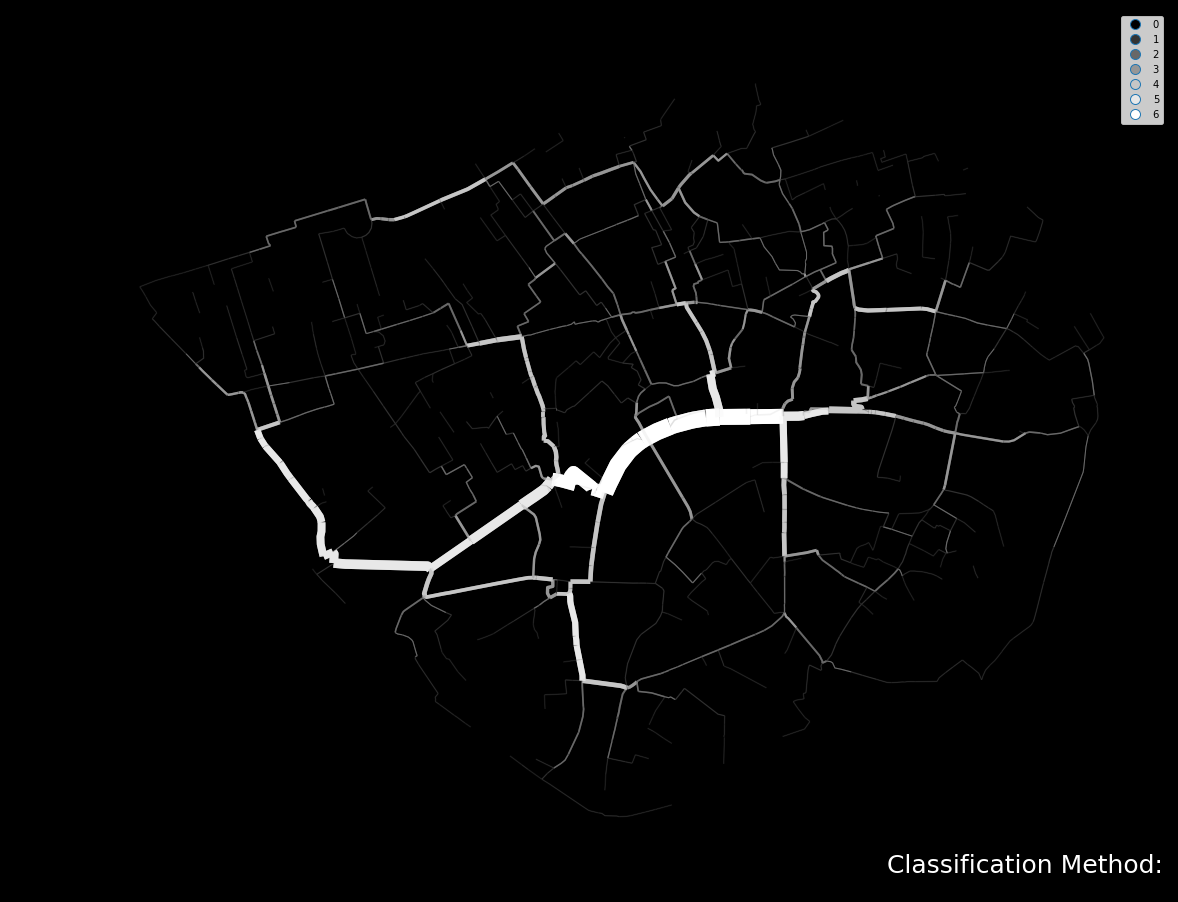

ValueError: Fewer unique values than specified classes.

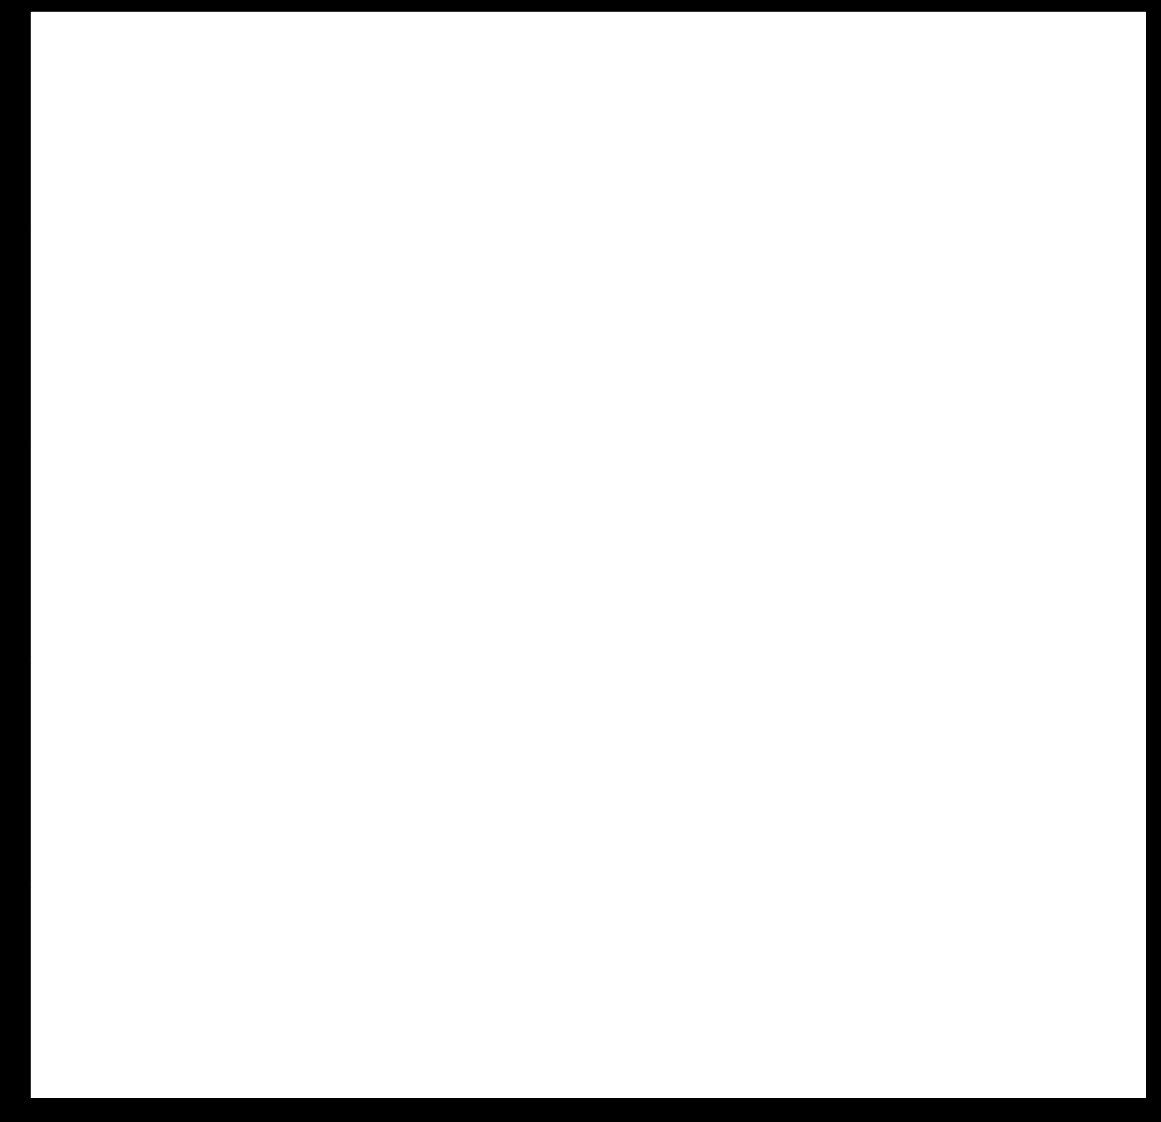

In [23]:
directory ='C:/Users/g_filo01/sciebo/Presentations/Agile/'

plot_grad_GDF(paths_data,"euclidean","euclidean", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"euclideanLand","euclideanLand", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"angular","angular", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"angularLand","angularLand", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"topological","topological", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"topologicalLand","topologicalLand", black_back = True, save = True, directory = directory)
plot_grad_GDF(paths_data,"landmark","topologicalLand", black_back = True, save = True, directory = directory)

In [ ]:
x = 5710464.32
y = 699978.99

In [ ]:
import folium

gjson = paths_data.to_crs(epsg='4326').to_json()

In [ ]:
m = folium.Map(location=[51.30, 0.7], zoom_start=7, tiles="cartodbpositron")

m.choropleth(
    geo_data=paths_data,
    data=paths_data,
    columns=['euclidean'],
    key_on='feature.properties.pfaf_7',
    legend_name='Area (sq mi)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True)

m

In [ ]:
ic.plot_grad_GDF(paths_data,"angular","euclidean", black_back = True)

In [ ]:
ic.plot_grad_GDF(paths_data,"angularLand","euclideanLand", black_back = True)

In [ ]:
ic.plot_grad_GDF(paths_data,"euclideanDiff","diff", cmap = 'bwr', black_back = False)

In [ ]:
nodes[(nodes.x > 530369)  & (nodes.x < 530370) ]